In [9]:
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.utils import Sequence

In [10]:
model = tf.keras.models.load_model('froged_segment.keras')

In [11]:
total_images = os.listdir("forgery/images")
test_images = total_images[int(0.9 * len(total_images)):]

In [13]:
class DataLoader(Sequence):
    
    def __init__(self, dataset_list,batch_size):
        self.dataset_list = dataset_list
        self.batch_size = batch_size
        np.random.shuffle(self.dataset_list)
        
    def __len__(self):
        return len(self.dataset_list) // self.batch_size
        
    def __getitem__(self, index):
        i = index * self.batch_size
        batch_input_data = self.dataset_list[i : i + self.batch_size]
        x = np.zeros((self.batch_size, 256, 256, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, 256, 256, 1), dtype=np.float32)
        for j, image_name in enumerate(batch_input_data):
            image = cv2.imread("forgery/images/{}".format(image_name))
            if "O" not in image_name:
                mask = cv2.imread("forgery/labels/{}_B.png".format(image_name.split("_")[0]), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (256, 256))
                mask = np.reshape(mask, (256, 256, 1))
            else:
                mask = np.zeros((256, 256, 1), dtype=np.float32)
            image = cv2.resize(image, (256, 256))
            x[j] = image
            y[j] = mask       
            
        return adjust_data(x,y)

In [15]:
def adjust_data(image, mask):
    image = image / 255
    mask = mask / 255
    
    return image, mask

In [16]:
test_datagen = DataLoader(test_images, 64)
result = model.predict(test_datagen, verbose=1)

C:\Users\amrit\OneDrive\Desktop\tf-kernal\tf-kernal\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 127s 8s/step


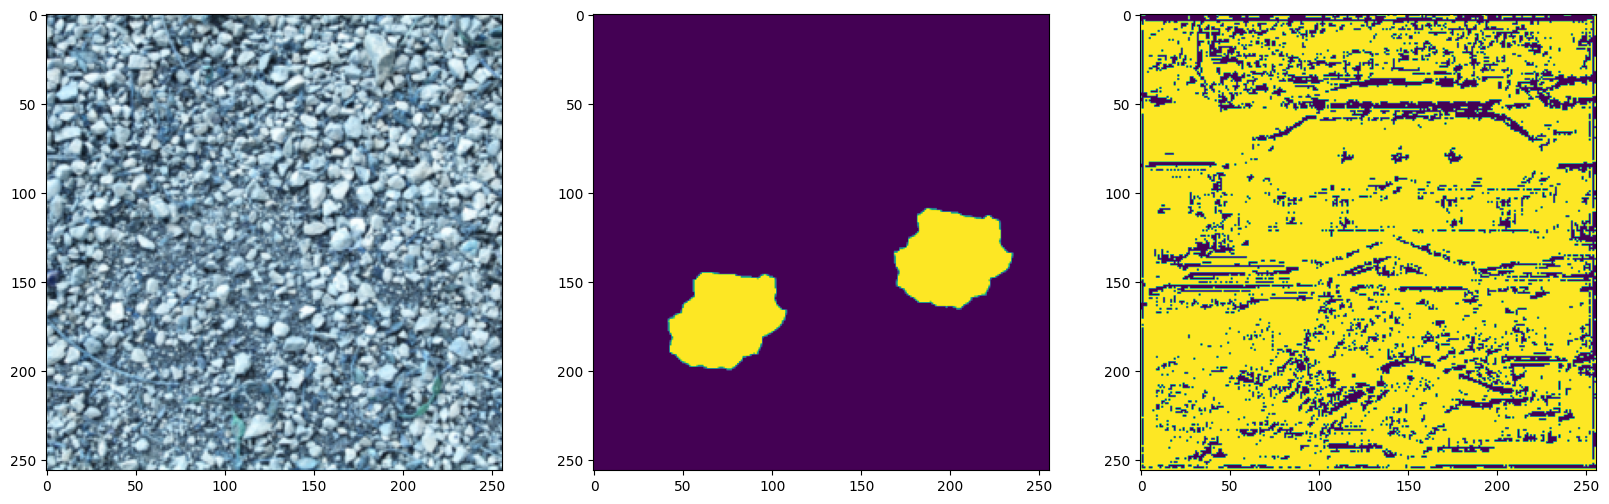

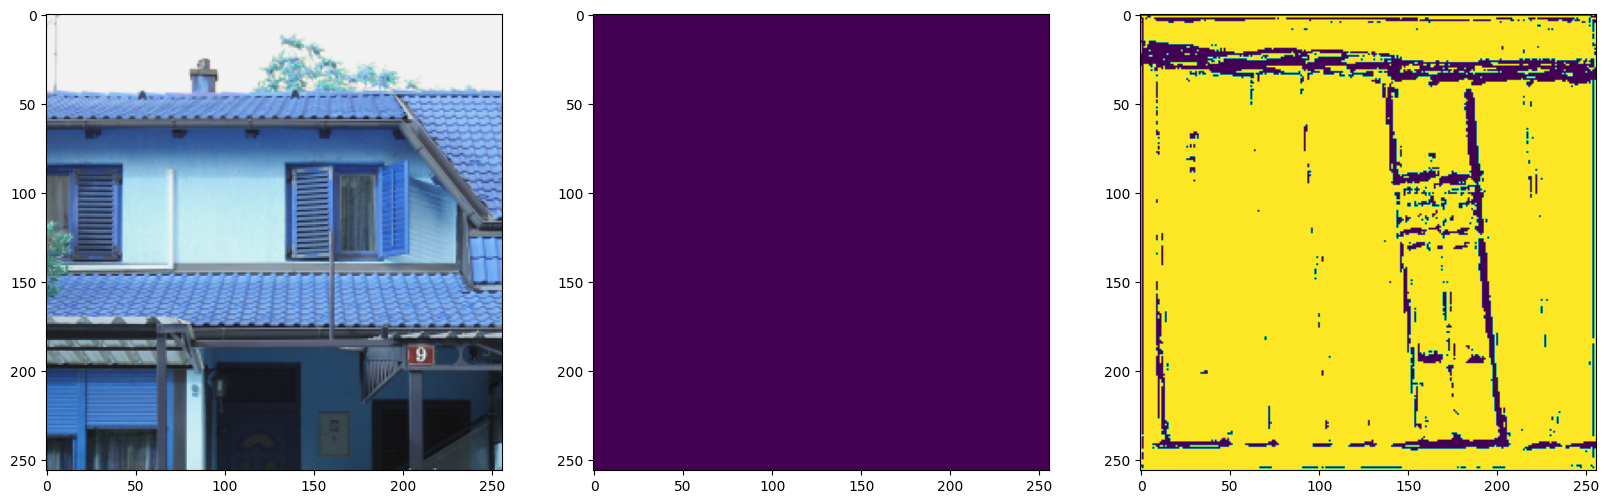

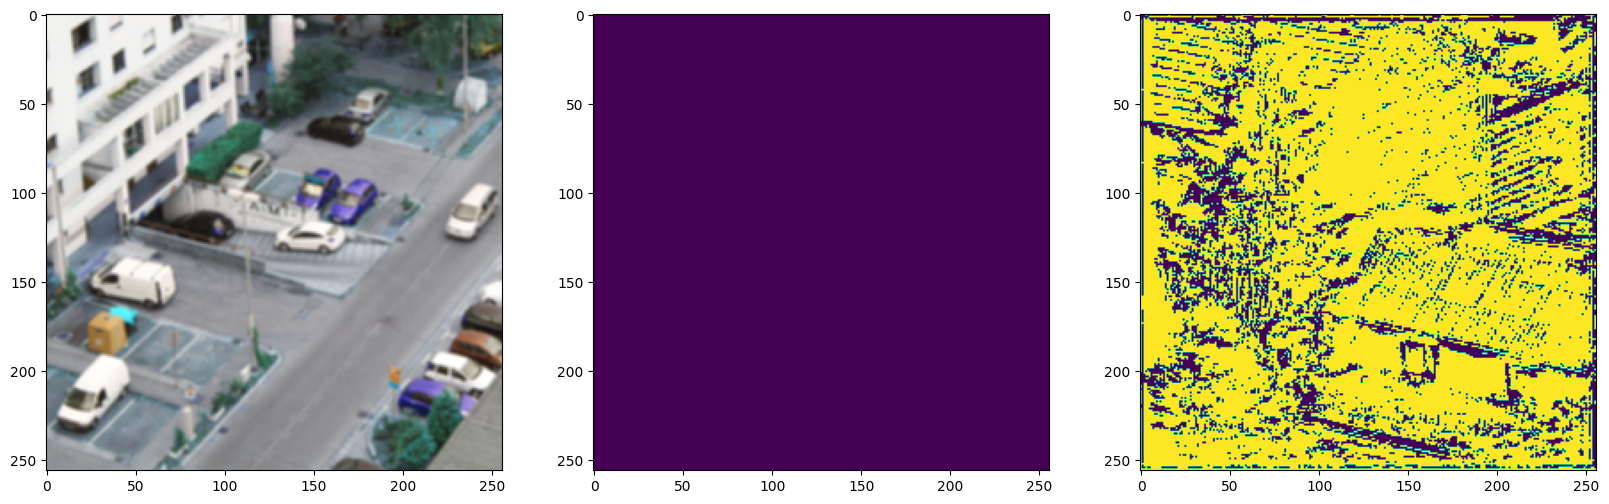

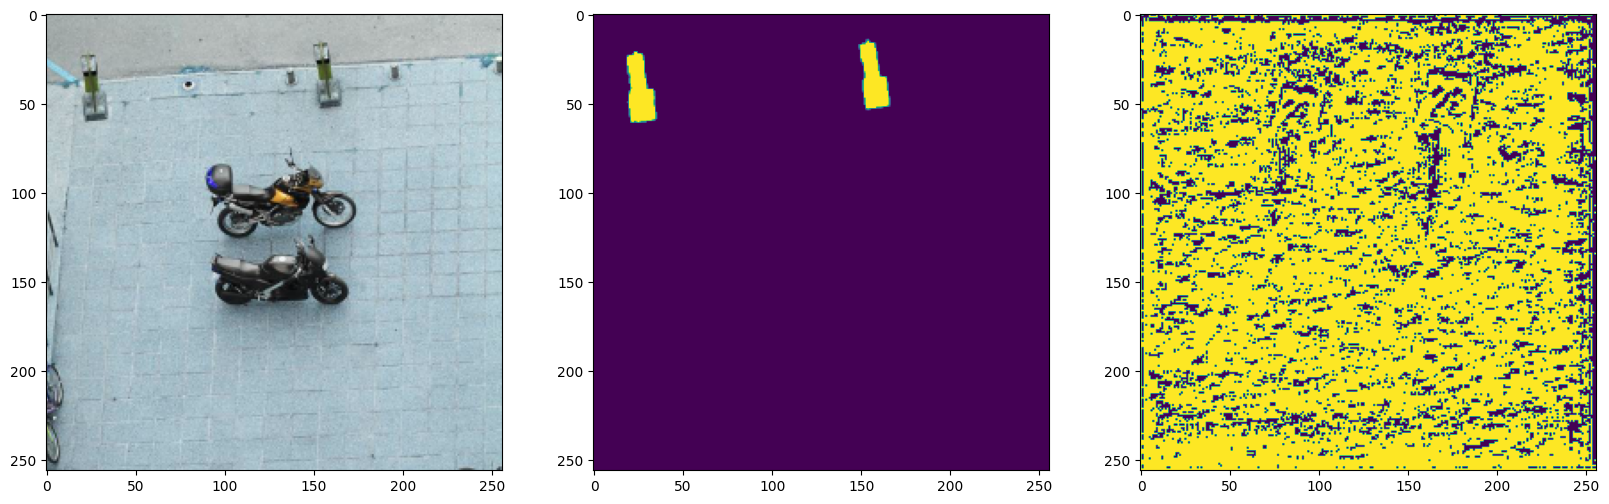

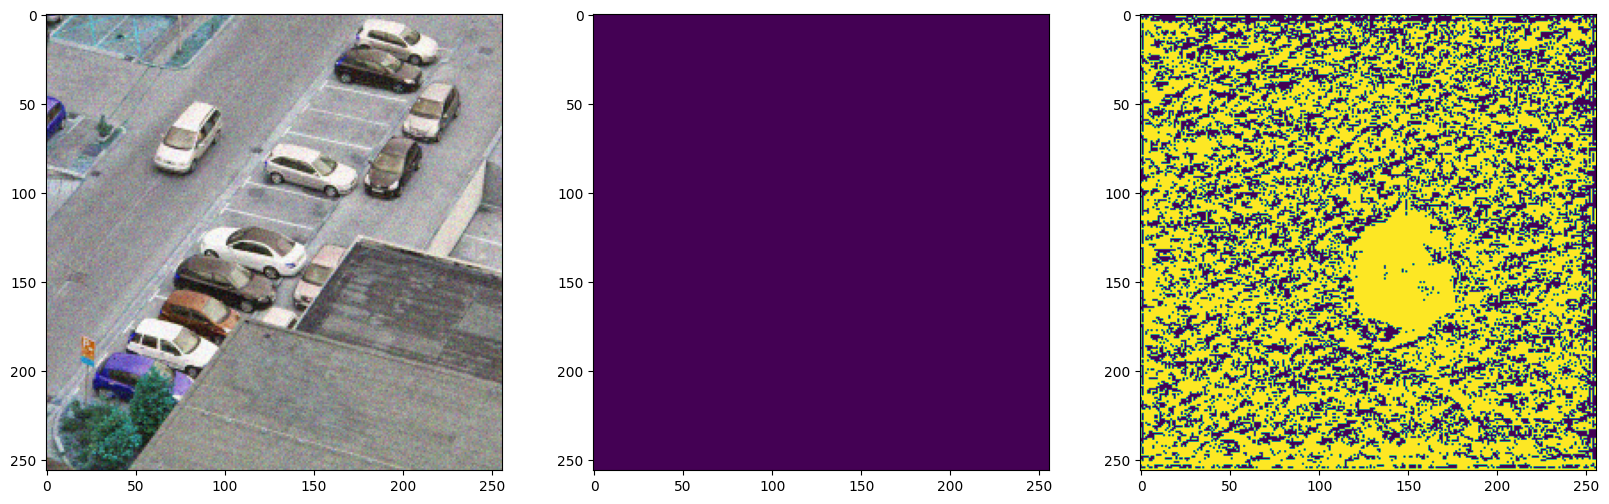

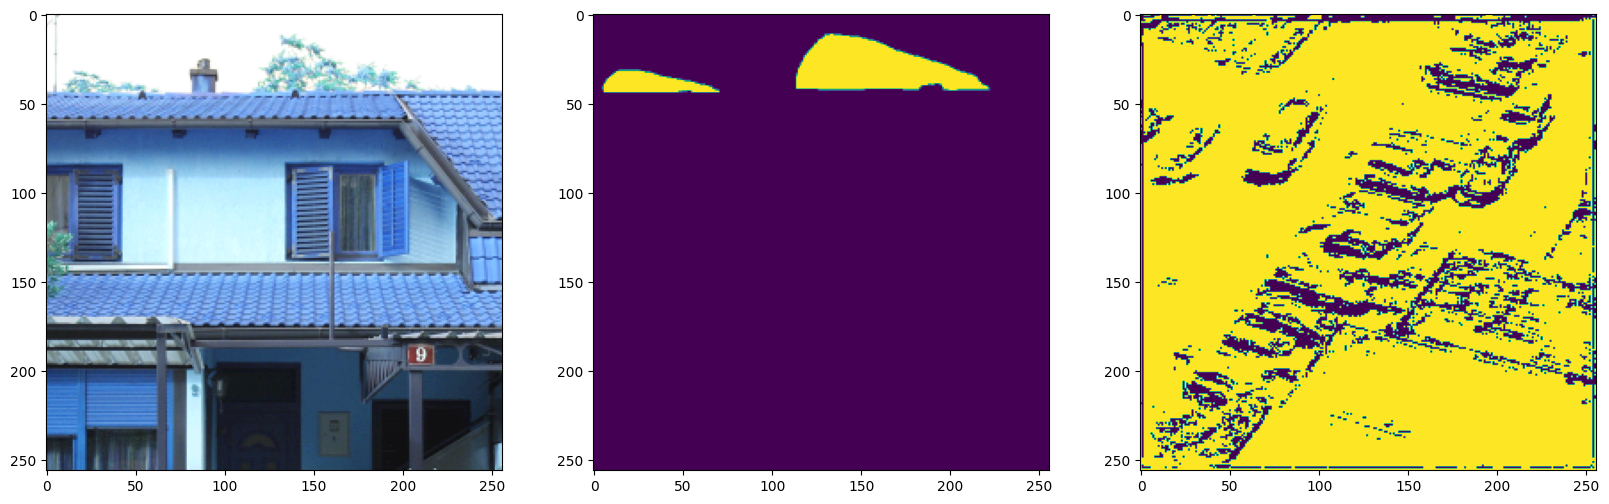

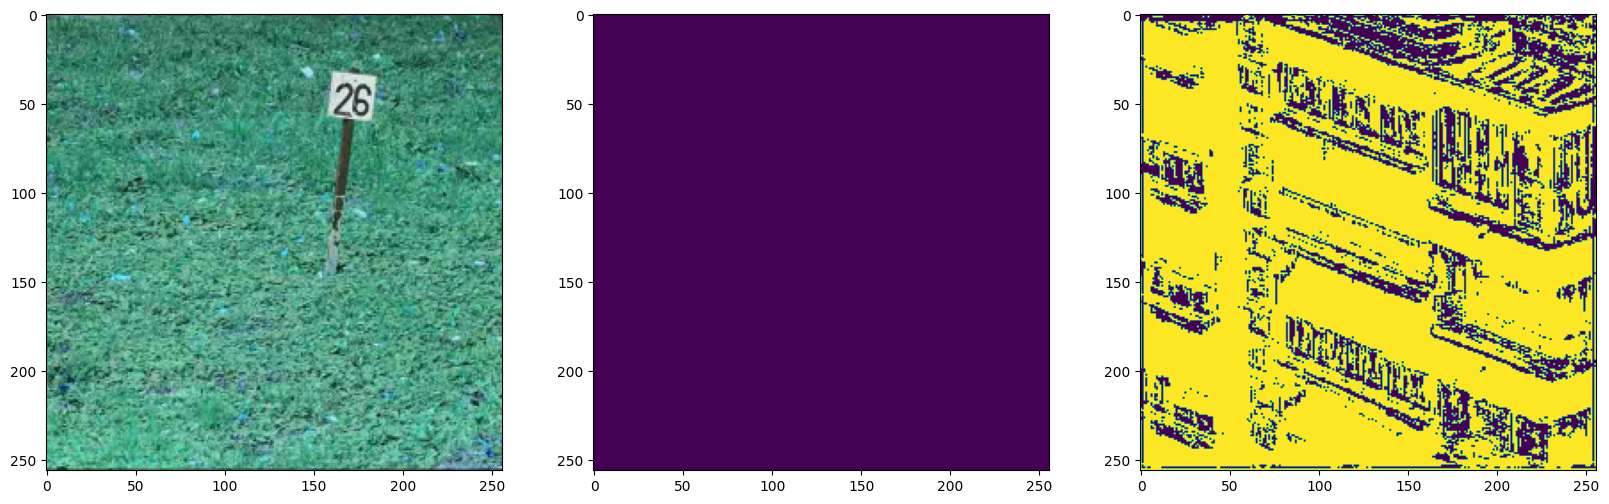

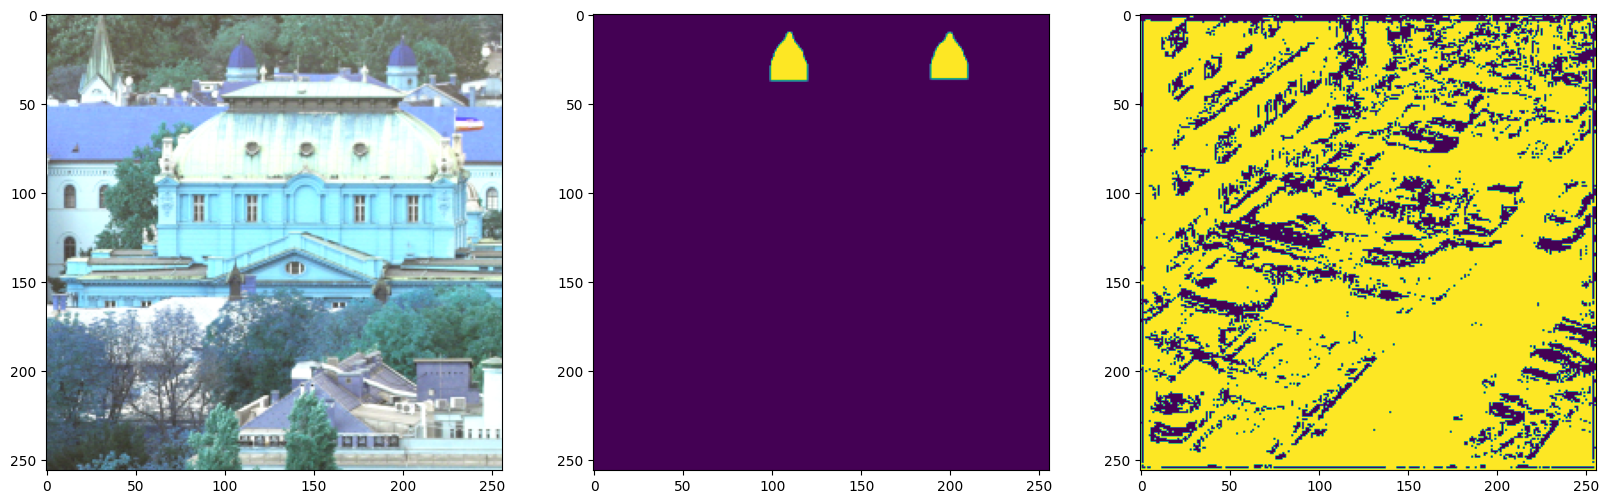

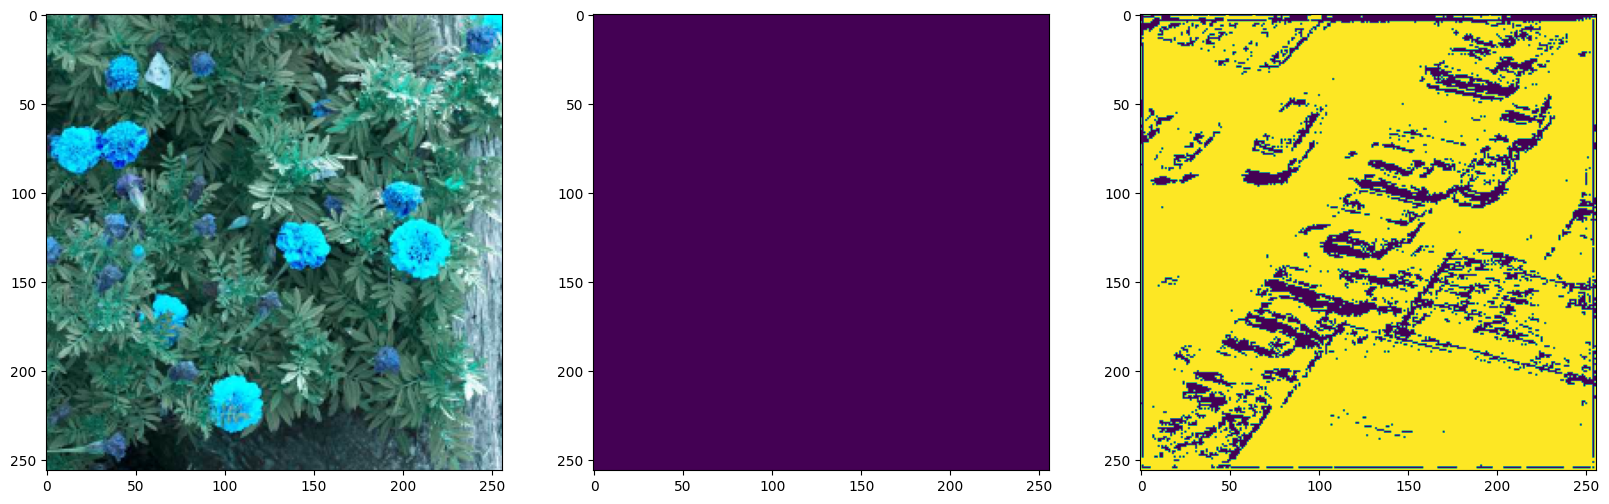

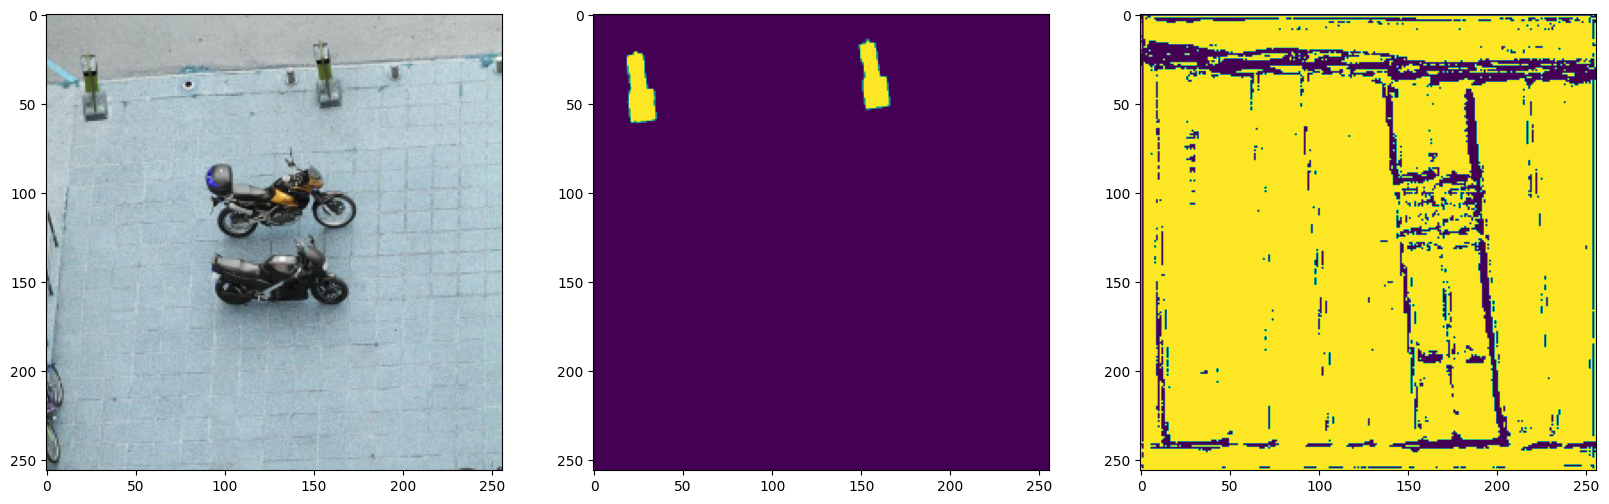

In [18]:
for i, res in enumerate(result[70:80]):
    image_name = test_images[i + 50]
    image = cv2.imread("forgery/images/{}".format(image_name), cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))
    if "O" not in image_name:
        mask = cv2.imread("forgery/labels/{}_B.png".format(image_name.split("_")[0]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
    else:
        mask = np.zeros((256, 256, 1), dtype=np.float32)
    
    res[res>0.5] = 1
    res[res<0.5] = 0
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
    ax1.imshow(image)
    ax2.imshow(mask)
    ax3.imshow(res)